# Install packages

In [1]:
!pip install hopsworks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.6/120.6 KB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 KB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/134.7 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.2/68.2 KB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 KB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 M

# Import packages

In [2]:
import os
import hopsworks
import pandas as pd
import numpy as np
import joblib
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
#os.environ['EIA_API_KEY'] = "4goTb0VNLmTBcF4hd6VyD1BHsJNcgA6ufRW4R6ax"
#from dotenv import load_dotenv
#%load_ext dotenv

# Connect to GDrive

In [3]:
from google.colab import drive

drive.mount("/content/gdrive")
os.chdir("gdrive/MyDrive/Serverless/ElectricityDemand/")

Mounted at /content/gdrive


# Hopsworks - Feature Store

In [4]:
# Login to hopsworks
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/3355
Connected. Call `.close()` to terminate connection gracefully.


In [5]:
try:
  fview = fs.get_feature_view(name="ny_elec", version = 1)
except:
  fg = fs.get_feature_group(name="ny_elec", version=1)
  query = fg.select_except(["date"]) # date not needed for training
  fview = fs.create_feature_view(name="ny_elec",
                                 version=1,
                                 description="read from NY Electricity data",
                                 labels=["demand"],
                                 query=query)

In [6]:
seed = np.random.RandomState(65)
seed.rand()

0.21864505014720603

# Train/Test Split

In [7]:
X_train, X_test, y_train, y_test = fview.train_test_split(0.2)

# Data Prep Pipeline

In [10]:
cols = ['temperature']

prepare = Pipeline([('impute', SimpleImputer()),
                    ('scale', MinMaxScaler()),
                    ])

column_trans = ColumnTransformer([('prepare', prepare, cols)],
                                 remainder='passthrough',
                                 verbose_feature_names_out=False)

In [12]:
kf = RepeatedKFold(n_splits=10, random_state=seed)

In [16]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=seed) # default metric

xgb_pipeline = Pipeline([('data_prep', column_trans),
                         ('xgb', xgb)
                         ])

params = {
    'xgb__learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    'xgb__max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
    'xgb__min_child_weight': [1, 3, 5, 7],
    'xgb__gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
    'xgb__colsample_bytree': [0.3, 0.4, 0.5, 0.7]
}

In [17]:
gs_xgb = RandomizedSearchCV(xgb_pipeline,
                            random_state=seed,
                            param_distributions=params,
                            cv=kf,
                            verbose=3,
                            n_jobs=-1)

In [18]:
gs_xgb.fit(X_train, y_train)

Fitting 100 folds for each of 10 candidates, totalling 1000 fits


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=10,
       random_state=RandomState(MT19937) at 0x7FB32F6E2740),
                   estimator=Pipeline(steps=[('data_prep',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('prepare',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer()),
                                                                                               ('scale',
                                                                                                MinMaxScaler())]),
                                                                               ['temperature'])],
                                                                verbose_feature_names_out=False)),
 

In [20]:
gs_xgb.best_params_
gs_xgb.best_score_

0.8906822125755669

In [21]:
# Get best model
model = gs_xgb.best_estimator_

In [22]:
y_pred = model.predict(X_test)
mean_error = mean_absolute_error(y_test, y_pred)
mean_error

14296.148992486338

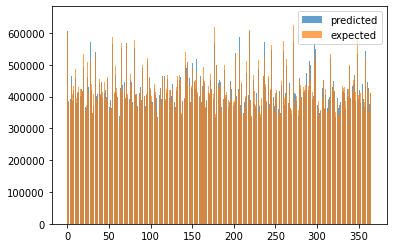

In [23]:
pyplot.bar(x=np.arange(len(y_pred)), height=y_pred, label='predicted', alpha=0.7)
pyplot.bar(x=np.arange(len(y_pred)), height=y_test['demand'].to_numpy(), label='expected', alpha=0.7)
pyplot.legend()
pyplot.show()

In [24]:
# Store model on hopsworks
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


In [25]:
model_dir = "model"
if not os.path.isdir(model_dir):
  os.mkdir(model_dir)

In [26]:
joblib.dump(model, model_dir + "/ny_elec_model.pkl")

['model/ny_elec_model.pkl']

In [27]:
# Specify the schema of model 
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

In [28]:
ny_elec_model = mr.python.create_model(name="ny_elec_model",
                                       metrics={"mean_absolute_error": mean_error},
                                       model_schema=model_schema,
                                       description="NY Electricity Demand Predictor")

In [29]:
ny_elec_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/3355/models/ny_elec_model/1


Model(name: 'ny_elec_model', version: 1)